,Commodity price (¢/m³),Gas cost adjustment (¢/m³),Effective price (¢/m³)
Date,,,
2023-10-01,13.1971,3.6781,16.8752
2023-07-01,11.9070,3.8665,15.7735
2023-04-01,13.2318,2.0386,15.2704
2023-01-01,21.2666,1.7667,23.0333
2022-10-01,27.6575,0.2452,27.9027


(0.0, 42.85564)

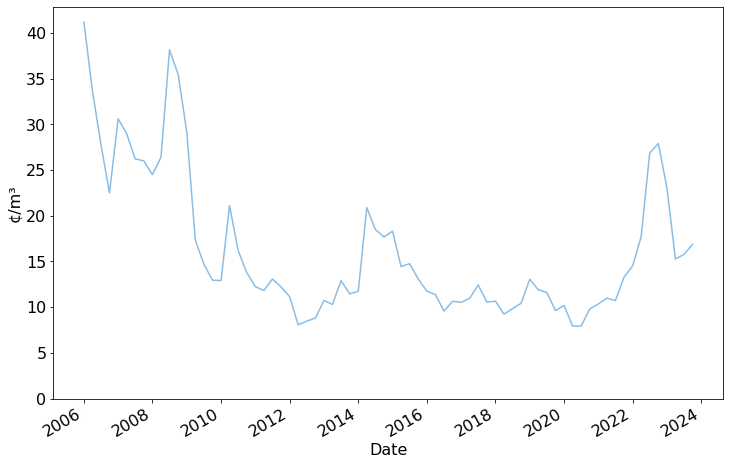

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

sys.path.insert(0, os.path.join(".."))

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler

%matplotlib inline

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
def scale_rgb(colormap):
    return [(r / 255., g / 255., b / 255.) for r, g, b in colormap]

light = scale_rgb([
    (136, 189, 230),
    (251, 178, 88),
    (144, 205, 151),
    (246, 170, 201),
    (191, 165, 84),
    (188, 153, 199),
    (237, 221, 70),
    (240, 126, 110),
    (140, 140, 140)])

rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 16,
    'axes.prop_cycle': cycler('color', light)
})

df_gas = pd.read_csv("https://raw.githubusercontent.com/ryanfobel/ontario-grid-data/main/data/clean/oeb.ca/natural%20gas/Enbridge%20Gas.csv", index_col=0)
df_gas.index = pd.to_datetime(df_gas.index)
display(df_gas.head())
df_gas["Effective price (¢/m³)"].plot()
plt.ylabel("¢/m³")
plt.ylim([0, None])

Text(0.5, 0, '')

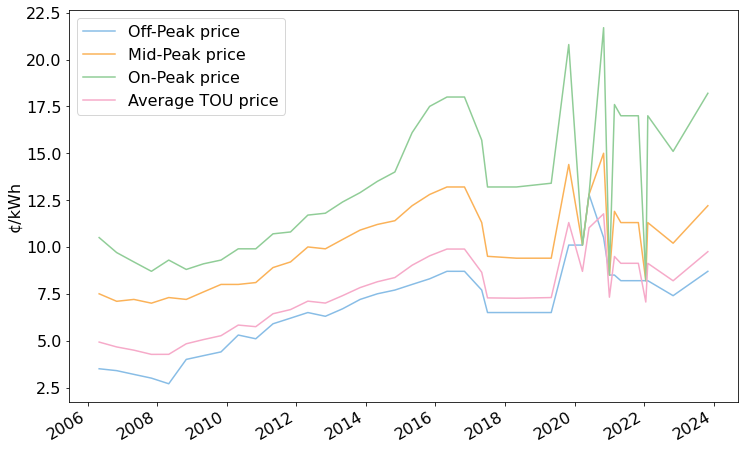

In [2]:
df_tou = pd.read_csv("https://raw.githubusercontent.com/ryanfobel/ontario-grid-data/main/data/clean/oeb.ca/electricity/Time-of-Use%20(TOU)%20rates.csv", index_col=0)
df_tou.index = pd.to_datetime(df_tou.index)

n_holidays = 10
df_tou["Average TOU price (¢ per kWh)"] = (
    (
        df_tou["Off-Peak price (¢ per kWh)"] * 7 * 12 + df_tou["Mid-Peak price (¢ per kWh)"] * 5 * 6 + df_tou["On-Peak price (¢ per kWh)"] * 5 * 6
    ) / (7 * 24) * (365 - n_holidays) +
    (
        n_holidays * df_tou["Off-Peak price (¢ per kWh)"]
    ) 
) / 365
df_tou.rename(
    columns={c: c.replace(" (¢ per kWh)", "") for c in df_tou.columns}
).plot()
plt.ylabel("¢/kWh")
plt.xlabel(None)

In [3]:
df_ulo = pd.read_csv("https://raw.githubusercontent.com/ryanfobel/ontario-grid-data/main/data/clean/oeb.ca/electricity/Ultra-Low%20Overnight%20(ULO).csv", index_col=0)
df_ulo.index = pd.to_datetime(df_ulo.index)
df_ulo

,Ultra-Low Overnight (¢ per kWh),Weekend Off-Peak price (¢ per kWh),Mid-Peak price (¢ per kWh),On-Peak price (¢ per kWh)
Effective date,,,,
2023-11-01,2.8,8.7,12.2,28.6
2023-05-01,2.4,7.4,10.2,24.0


In [4]:
# https://www.enbridgegas.com/en/residential/my-account/rates/federal-carbon-charge
carbon_charge = pd.DataFrame(
    data={
        #"Federal carbon charge ($/tCO2e)": [3.91, 5.87, 7.83, 9.79, 12.39, 15.25, 18.11, 20.97, 23.83, 26.69, 29.54, 32.4],
        "Federal carbon charge (¢/m³)": [3.91, 5.87, 7.83, 9.79, 12.39, 15.25, 18.11, 20.97, 23.83, 26.69, 29.54, 32.4]
    },
    index=range(2019, 2031)
)
carbon_charge

,Federal carbon charge (¢/m³)
2019,3.91
2020,5.87
2021,7.83
2022,9.79
2023,12.39
2024,15.25
2025,18.11
2026,20.97
2027,23.83
2028,26.69


In [5]:
df_gas["year"] = df_gas.index.year
df_gas = df_gas.join(
    carbon_charge,
    on="year"
).drop(columns="year").fillna(0)

# Fixed cost /m³ depends on how much gas you use
annual_gas_consumption_m3 = 1600
annual_fixed_cost = 0.76*365*100

# Where can we get historical rates for these?
df_gas["Variable delivery charge (¢/m³)"] = 9
df_gas["Fixed charge (¢/m³)"] = annual_fixed_cost / annual_gas_consumption_m3

variable_components = [
    "Variable delivery charge (¢/m³)",
    "Federal carbon charge (¢/m³)",
    "Effective price (¢/m³)",
]
fixed_components = ['Fixed charge (¢/m³)']
df_gas = df_gas[variable_components + fixed_components]
df_gas["Total [variable + fixed] (¢/m³)"] = df_gas.sum(axis=1)
df_gas["Total [variable] (¢/m³)"] = df_gas[variable_components].sum(axis=1)
df_gas

,Variable delivery charge (¢/m³),Federal carbon charge (¢/m³),Effective price (¢/m³),Fixed charge (¢/m³),Total [variable + fixed] (¢/m³),Total [variable] (¢/m³)
Date,,,,,,
2023-10-01,9,12.39,16.8752,17.3375,55.6027,38.2652
2023-07-01,9,12.39,15.7735,17.3375,54.5010,37.1635
2023-04-01,9,12.39,15.2704,17.3375,53.9979,36.6604
2023-01-01,9,12.39,23.0333,17.3375,61.7608,44.4233
2022-10-01,9,9.79,27.9027,17.3375,64.0302,46.6927
...,...,...,...,...,...,...
2007-01-01,9,0.00,30.6109,17.3375,56.9484,39.6109
2006-10-01,9,0.00,22.5072,17.3375,48.8447,31.5072
2006-07-01,9,0.00,27.8287,17.3375,54.1662,36.8287


Text(0, 0.5, '¢/kWh')

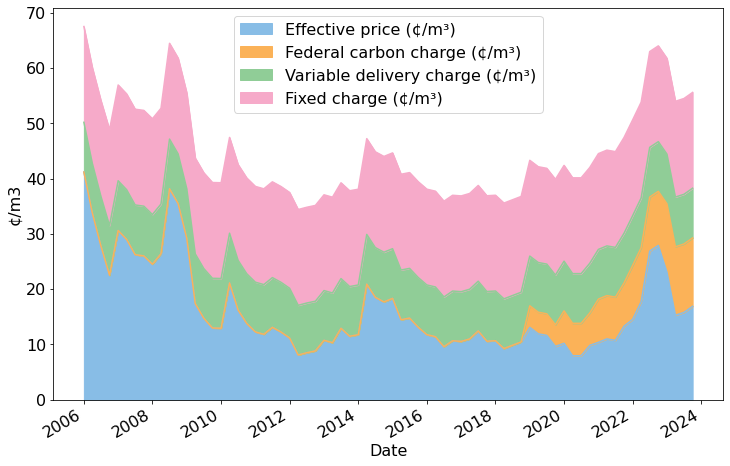

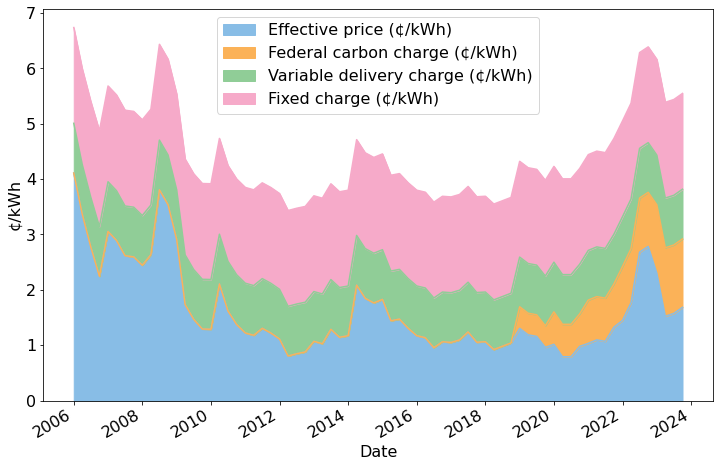

In [10]:
furnace_efficiency = 0.95
kWh_per_m3 = 10.55

components = [
    "Effective price",
    "Federal carbon charge",
    "Variable delivery charge",
    "Fixed charge",
]
totals = [
    "Total [variable + fixed]",
    "Total [variable]",
]
components_m3 = [c + " (¢/m³)" for c in components]
totals_m3 = [t + " (¢/m³)" for t in totals]
components_kWh = [c + " (¢/kWh)" for c in components]
totals_kWh = [t + " (¢/kWh)" for t in totals]
df_gas[components_kWh + totals_kWh] = df_gas[components_m3 + totals_m3] / kWh_per_m3 / furnace_efficiency

df_gas[components_m3].plot.area()
plt.ylabel("¢/m3")

df_gas[components_kWh].plot.area()
plt.ylabel("¢/kWh")